# Regresión sobre el precio de vehículos de segunda mano
Este notebook muestra el proceso completo del proyecto para predecir el precio de un vehículo de segunda mano a partir de sus características.

## 1. Setup

Librerías importadas en el proyecto.

In [1]:
import numpy as np
import pandas as pd

import os
import warnings
import datetime
from collections import defaultdict
from itertools import product

from IPython.display import IFrame

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import parallel_backend

from scipy.stats import kstest, norm, mannwhitneyu, f_oneway
from scipy.sparse import issparse

Variables globales utilizadas.

In [2]:
RANDOM_SEED = 1337

DATA_PATH = os.path.join(os.pardir, "data")
RESULTS_PATH = os.path.join(os.pardir, "results")

DATE_BASELINE = 2020 # Year of the last update made to the dataset
CV_FOLDS = 5 # Cross-validation fold count

Enunciado del problema.

In [3]:
# Jupyter Notebook only
IFrame(os.path.join(os.pardir, "info", "lab1.pdf"), width=1200, height=920)

## 2. Análisis exploratorio de los datos

Vamos a cargar todos los datos en memoria y a echarles un primer vistazo.

In [4]:
dataframes = {}
for file in filter(lambda x: x.endswith(".csv"), os.listdir(DATA_PATH)):
    name = file.split(".")[0]
    print(name)
    dataframes[name] = pd.read_csv(os.path.join(DATA_PATH, file))
    display(dataframes[name])

toyota


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0
...,...,...,...,...,...,...,...,...,...
6733,IQ,2011,5500,Automatic,30000,Petrol,20,58.9,1.0
6734,Urban Cruiser,2011,4985,Manual,36154,Petrol,125,50.4,1.3
6735,Urban Cruiser,2012,4995,Manual,46000,Diesel,125,57.6,1.4
6736,Urban Cruiser,2011,3995,Manual,60700,Petrol,125,50.4,1.3


skoda


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Octavia,2017,10550,Manual,25250,Petrol,150,54.3,1.4
1,Citigo,2018,8200,Manual,1264,Petrol,145,67.3,1.0
2,Octavia,2019,15650,Automatic,6825,Diesel,145,67.3,2.0
3,Yeti Outdoor,2015,14000,Automatic,28431,Diesel,165,51.4,2.0
4,Superb,2019,18350,Manual,10912,Petrol,150,40.9,1.5
...,...,...,...,...,...,...,...,...,...
6262,Yeti,2014,11440,Semi-Auto,14569,Petrol,160,44.8,1.2
6263,Octavia,2014,10990,Semi-Auto,49999,Petrol,30,56.5,1.4
6264,Fabia,2017,9500,Semi-Auto,17131,Petrol,145,61.4,1.0
6265,Citigo,2016,5999,Manual,21747,Petrol,20,62.8,1.0


bmw


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0
...,...,...,...,...,...,...,...,...,...
10776,X3,2016,19000,Automatic,40818,Diesel,150,54.3,2.0
10777,5 Series,2016,14600,Automatic,42947,Diesel,125,60.1,2.0
10778,3 Series,2017,13100,Manual,25468,Petrol,200,42.8,2.0
10779,1 Series,2014,9930,Automatic,45000,Diesel,30,64.2,2.0


ford


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


cclass


,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Corsa,2018,7885,Manual,9876,Petrol,145,55.4,1.4
1,Corsa,2019,11995,Manual,2500,Petrol,145,54.3,1.4
2,Corsa,2017,9777,Automatic,9625,Petrol,145,47.9,1.4
3,Corsa,2016,8500,Manual,25796,Petrol,30,55.4,1.4
4,Corsa,2019,10000,Manual,3887,Petrol,145,43.5,1.4
...,...,...,...,...,...,...,...,...,...
13627,Tigra,2007,2499,Manual,48640,Petrol,165,46.3,1.4
13628,Vectra,2007,1795,Manual,75000,Petrol,240,39.2,1.8
13629,Vectra,2005,1495,Manual,74000,Petrol,235,38.7,1.8
13630,Vectra,2008,1695,Automatic,131000,Diesel,200,39.8,1.9


merc


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0
...,...,...,...,...,...,...,...,...,...
13114,C Class,2020,35999,Automatic,500,Diesel,145,55.4,2.0
13115,B Class,2020,24699,Automatic,2500,Diesel,145,55.4,2.0
13116,GLC Class,2019,30999,Automatic,11612,Diesel,145,41.5,2.1
13117,CLS Class,2019,37990,Automatic,2426,Diesel,145,45.6,2.0


focus


,model,year,price,transmission,mileage,fuelType,engineSize
0,Focus,2016,8000,Manual,38852,Petrol,1.0
1,Focus,2019,13400,Manual,11952,Petrol,1.0
2,Focus,2019,14600,Manual,22142,Petrol,1.5
3,Focus,2016,9450,Manual,14549,Diesel,1.6
4,Focus,2015,9999,Manual,7010,Diesel,1.6
...,...,...,...,...,...,...,...
5449,Focus,2019,18745,Manual,7855,Diesel,2.0
5450,Focus,2019,16350,Manual,13891,Petrol,1.0
5451,Focus,2019,16850,Manual,13452,Petrol,1.0
5452,Focus,2019,17310,Automatic,13376,Petrol,1.0


vw


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5
...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
15153,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
15154,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
15155,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


hyundi


,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0
...,...,...,...,...,...,...,...,...,...
4855,I30,2016,8680,Manual,25906,Diesel,0,78.4,1.6
4856,I40,2015,7830,Manual,59508,Diesel,30,65.7,1.7
4857,I10,2017,6830,Manual,13810,Petrol,20,60.1,1.0
4858,Tucson,2018,13994,Manual,23313,Petrol,145,44.8,1.6


audi


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


Lo primero que se ve es que casi todos los ficheros tienen las mismas columnas. Las variables `model`, `transmission` y `fueltype` son categóricas y el resto son numéricas. Hay un par de problemas a primera vista, como que `hyundi.csv` tiene un nombre diferente en la columna `tax` y que a dos ficheros les faltan las columnas `tax` y `mpg`.

### 2.1. Análisis de los ficheros de la misma marca

En primer lugar se ve que los archivos `cclass.csv` y `focus.csv` no tienen las columnas `tax` y `mpg`. Ya que estos son modelos de otras marcas (Ford en `ford.csv` y Mercedes en `merc.csv`), vamos a ver si podemos mezclarlos con el resto de modelos de la marca.

In [5]:
print(dataframes["focus"]["model"].unique())
print(dataframes["ford"]["model"].unique())

[' Focus']
[' Fiesta' ' Focus' ' Puma' ' Kuga' ' EcoSport' ' C-MAX' ' Mondeo' ' Ka+'
 ' Tourneo Custom' ' S-MAX' ' B-MAX' ' Edge' ' Tourneo Connect'
 ' Grand C-MAX' ' KA' ' Galaxy' ' Mustang' ' Grand Tourneo Connect'
 ' Fusion' ' Ranger' ' Streetka' ' Escort' ' Transit Tourneo']


In [6]:
print(dataframes["cclass"]["model"].unique())
print(dataframes["merc"]["model"].unique())

[' C Class']
[' SLK' ' S Class' ' SL CLASS' ' G Class' ' GLE Class' ' GLA Class'
 ' A Class' ' B Class' ' GLC Class' ' C Class' ' E Class' ' GL Class'
 ' CLS Class' ' CLC Class' ' CLA Class' ' V Class' ' M Class' ' CL Class'
 ' GLS Class' ' GLB Class' ' X-CLASS' '180' ' CLK' ' R Class' '230' '220'
 '200']


El nombre del modelo coincide con lo que se espera: todos los vehículos de `focus.csv` son modelo Focus y todos los de `cclass.csv` son de modelo C Class.

Ya que no conocemos de dónde vienen los datos, una posibilidad es que todas las filas de `cclass.csv` y `focus.csv` provengan originalmente de `merc.csv` y `ford.csv` respectivamente. Si añadimos esas filas sin pensar mucho, es posible que estemos duplicando algunos datos sin razón. Vamos a ver si son duplicados:

In [7]:
columns = [
    "model", "year", "price", "transmission", "mileage", "fuelType",
    "engineSize"
]

df_merged_ford = dataframes["ford"][columns].merge(dataframes["focus"][columns],
                                                   how="outer", indicator="union")
df_merged_merc = dataframes["merc"][columns].merge(dataframes["cclass"][columns],
                                                   how="outer", indicator="union")

focus_unique = df_merged_ford[df_merged_ford.union == "right_only"].drop(columns=["union"])
cclass_unique = df_merged_merc[df_merged_merc.union == "right_only"].drop(columns=["union"])

print("Unique rows in focus.csv:", len(focus_unique))
print("Unique rows in cclass.csv:", len(cclass_unique))

print("Duplicated rows in focus.csv:",
      len(dataframes["focus"]) - len(focus_unique))
print("Duplicated rows in cclass.csv:",
      len(dataframes["cclass"]) - len(cclass_unique))

Unique rows in focus.csv: 784
Unique rows in cclass.csv: 265
Duplicated rows in focus.csv: 4670
Duplicated rows in cclass.csv: 3634


Aunque la mayoría de las filas son duplicadas, hay una proporción alta de filas nuevas y usables. Lo que haremos será escoger sólo los DataFrames de `focus_unique` y `cclass_unique` para mezclar con `ford.csv` y `merc.csv`.

### 2.2. Análisis antes de mezclar los ficheros

Vamos a hacer unos análisis preliminares para ver si es posible, y en caso de que lo sea, cuánto trabajo llevaría, mezclar todos los ficheros csv en un solo `DataFrame`.

#### 2.2.2. Nombre de modelo único

Para los modelos de regresión, lo ideal sería que se sepa la marca de la instancia como algo separado del modelo, ya que es posible que haya marcas de lujo que siempre cuesten más independientemente de las características del vehículo. Sin embargo, si el nombre del modelo de vehículo está repetido para distintas marcas, eso puede dar lugar a problemas. Vamos a comprobar si es el caso:

In [8]:
car_models = set()
for key in dataframes:
    make_models = set(dataframes[key]["model"].unique())
    intersect = car_models & make_models
    if intersect != set():
        print(key, intersect)
    car_models |= make_models

merc {' C Class'}
focus {' Focus'}


Ya sabíamos que esos dos iban a fallar, pero hemos visto que ninguno más nos da problemas.

### 2.3. Creación de un único DataFrame

Vamos a juntar todos los dataframes de los distintos ficheros csv en un solo objeto que podremos evaluar más adelante.

Antes de nada, renombramos la columna `tax` de Hyundai para que sea consistente con las demás.

In [9]:
dataframes["hyundi"].rename(columns={"tax(£)": "tax"}, inplace=True)

Vamos a mezclar los archivos `merc.csv` con las filas no duplicadas de `cclass.csv` y `ford.csv` con `focus.csv`. Esto significa que las filas que procedan de `cclass.csv` y `focus.csv` tendrán valores `nan` en las columnas `tax` y `mpg`, que es algo que tendremos que tener en cuenta más adelante.

In [10]:
dataframes["merc"] = dataframes["merc"].append(cclass_unique)
dataframes["ford"] = dataframes["ford"].append(focus_unique)
del dataframes["cclass"], dataframes["focus"]

Y ahora vamos a generar un único `DataFrame` que contenga todos los datos del proyecto. Para saber qué marca tiene cada instancia vamos a añadir una columna `make`.

In [11]:
columns = [
    "make", "model", "year", "transmission", "mileage", "fuelType", "tax",
    "mpg", "engineSize", "price"
]

df = pd.DataFrame(columns=columns)

for key in dataframes:
    dataframes[key]["make"] = key
    assert set(dataframes[key].columns) == set(columns)
    df = df.append(dataframes[key])

display(df)

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,toyota,GT86,2016,Manual,24089,Petrol,265,36.2,2.0,16000
1,toyota,GT86,2017,Manual,18615,Petrol,145,36.2,2.0,15995
2,toyota,GT86,2015,Manual,27469,Petrol,265,36.2,2.0,13998
3,toyota,GT86,2017,Manual,14736,Petrol,150,36.2,2.0,18998
4,toyota,GT86,2017,Manual,36284,Petrol,145,36.2,2.0,17498
...,...,...,...,...,...,...,...,...,...,...
10663,audi,A3,2020,Manual,4018,Petrol,145,49.6,1.0,16999
10664,audi,A3,2020,Manual,1978,Petrol,150,49.6,1.0,16999
10665,audi,A3,2020,Manual,609,Petrol,150,49.6,1.0,17199
10666,audi,Q3,2017,Automatic,8646,Petrol,150,47.9,1.4,19499


Este `df` es el dataframe que vamos a preprocesar más adelante. Pero antes de eso, vamos a explorar un poco más los datos.

### 2.4. Análisis de duplicados

Un modelo con datos duplicados tiende siempre a sesgarse hacia esos datos. Un 10% de datos duplicados eleva la probablidad de sesgar el modelo a un 89% \[1\]. Además, no podemos permitir que haya datos en el dataset de test que el modelo ya haya visto durante su entrenamiento.

In [13]:
duplicate_count = df.duplicated().sum()
print(duplicate_count)

1826


El procentaje de elementos duplicados no es muy alto para el problema, pero es una buena práctica eliminarlos, así que será un paso del preprocesamiento.

### 2.5. Análisis de variables numéricas

#### 2.5.1. Comprobaciones de los tipos de datos

Lo primero es ver si las variables numéricas realmente son tales. Es habitual que aparezcan en el `DataFrame` como `object` o `str`, así que tendremos que cambiar lo que corresponda.

In [14]:
df.dtypes

make             object
model            object
year             object
transmission     object
mileage          object
fuelType         object
tax              object
mpg             float64
engineSize      float64
price            object
dtype: object

Las variables `year`, `price`, `mileage`, y `tax` son numéricas, pero aparecen como `object`. Vamos a cambiarlo:

In [15]:
df["year"] = df["year"].astype("int32")
df[["price", "mileage", "tax"]] = df[["price", "mileage", "tax"]].astype("float64")
df

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,toyota,GT86,2016,Manual,24089.0,Petrol,265.0,36.2,2.0,16000.0
1,toyota,GT86,2017,Manual,18615.0,Petrol,145.0,36.2,2.0,15995.0
2,toyota,GT86,2015,Manual,27469.0,Petrol,265.0,36.2,2.0,13998.0
3,toyota,GT86,2017,Manual,14736.0,Petrol,150.0,36.2,2.0,18998.0
4,toyota,GT86,2017,Manual,36284.0,Petrol,145.0,36.2,2.0,17498.0
...,...,...,...,...,...,...,...,...,...,...
10663,audi,A3,2020,Manual,4018.0,Petrol,145.0,49.6,1.0,16999.0
10664,audi,A3,2020,Manual,1978.0,Petrol,150.0,49.6,1.0,16999.0
10665,audi,A3,2020,Manual,609.0,Petrol,150.0,49.6,1.0,17199.0
10666,audi,Q3,2017,Automatic,8646.0,Petrol,150.0,47.9,1.4,19499.0


#### 2.5.2. Búsqueda de datos erróneos

En esta sección obervaremos los datos numéricos de forma general, para ver si hay algo que destaque y pueda ser relevante. Además, es posible que haya datos erróneos. Vamos a buscarlos, y si los encontramos, a corregirlos.

In [16]:
df.describe()

,year,mileage,tax,mpg,engineSize,price
count,100236.000000,100236.000000,99187.000000,99187.000000,100236.000000,100236.000000
mean,2017.091305,23036.289587,120.299838,55.166825,1.662608,16814.906960
std,2.136268,21186.737063,63.150926,16.138522,0.557771,9847.369762
min,1970.000000,1.000000,0.000000,0.300000,0.000000,450.000000
25%,2016.000000,7417.750000,125.000000,47.100000,1.200000,10000.000000
50%,2017.000000,17363.000000,145.000000,54.300000,1.600000,14498.000000
75%,2019.000000,32299.000000,145.000000,62.800000,2.000000,20847.000000
max,2060.000000,323000.000000,580.000000,470.800000,6.600000,159999.000000


##### 2.5.2.1 Errores en `year`

Lo primero que salta a la vista es el año máximo. ¡Es imposible que haya vehículos de años posteriores al actual! Lo corregimos filtrando `df` a las filas con años menores o iguales al año actual.

In [17]:
df[df["year"] > DATE_BASELINE]

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
17726,ford,Fiesta,2060,Automatic,54807.0,Petrol,205.0,42.8,1.4,6495.0


In [18]:
df = df[df["year"] <= DATE_BASELINE]

##### 2.5.2.2 Errores en `mpg`

Si vemos, la variable `mpg` tiene su máximo en 470, dato sin duda ánomalo. Esto significa que hay un vehículo que tan solo gasta 0.5 litros a los 100 kilómetros (o el equivalente para un coche eléctrico si hablamos de un MPGequivalent) si hacemos una conversión. Veamos de que vehículo se trata:

In [19]:
df[df["mpg"] == 470.8]

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
32,bmw,i3,2016,Automatic,25269.0,Other,0.0,470.8,0.6,17100.0
621,bmw,i3,2017,Automatic,41949.0,Hybrid,140.0,470.8,0.0,19998.0
778,bmw,i3,2017,Automatic,41146.0,Hybrid,0.0,470.8,0.0,19998.0
780,bmw,i3,2017,Automatic,10839.0,Hybrid,0.0,470.8,0.0,21898.0
1866,bmw,i3,2017,Automatic,26965.0,Hybrid,140.0,470.8,0.0,19980.0
2352,bmw,i3,2016,Automatic,8421.0,Hybrid,0.0,470.8,0.0,19490.0
3277,bmw,i3,2016,Automatic,43695.0,Hybrid,0.0,470.8,0.0,16482.0
3628,bmw,i3,2015,Automatic,65800.0,Hybrid,0.0,470.8,0.0,14285.0
3913,bmw,i3,2017,Automatic,36429.0,Hybrid,0.0,470.8,0.0,18500.0
4100,bmw,i3,2017,Automatic,17338.0,Hybrid,135.0,470.8,0.0,19495.0


Parece que todos los registros con el valor 470.8 de `mpg` pertenecen al modelo bmw i3, el cual tiene modelos híbridos y eléctricos. Sin embargo, el MPGe de un BMW i3 de fábrica es 113 \[2\], y es de esperar que con el uso ese valor disminuya, pero nunca que aumente, y mucho menos hasta 470.

De hecho, según la Agencia de Protección del medio ambiente de los Estados Unidos (EPA \[3\]), el vehículo con mayor MPG o MPGe existente es el Tesla Model 3, con un MPGe de 141. Por tanto, vamos a eliminar las filas que presenten valores superiores a este.

In [20]:
df[df["mpg"] > 141]

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
6098,toyota,Prius,2017,Automatic,3881.0,Hybrid,135.0,235.0,1.8,20795.0
6103,toyota,Prius,2018,Automatic,16347.0,Hybrid,140.0,235.0,1.8,20495.0
6116,toyota,Prius,2017,Automatic,13476.0,Hybrid,140.0,235.0,1.8,19998.0
6118,toyota,Prius,2019,Automatic,6552.0,Hybrid,135.0,235.0,1.8,24987.0
6124,toyota,Prius,2020,Automatic,1500.0,Hybrid,135.0,235.0,1.8,27990.0
...,...,...,...,...,...,...,...,...,...,...
8875,audi,A3,2015,Automatic,72260.0,Hybrid,0.0,176.6,1.4,11295.0
10003,audi,A3,2016,Automatic,72800.0,Hybrid,0.0,176.6,1.4,13000.0
10185,audi,A3,2015,Automatic,89000.0,Hybrid,0.0,176.6,1.4,11240.0
10392,audi,A3,2015,Automatic,63000.0,Hybrid,0.0,188.3,1.4,14000.0


In [21]:
df = df[df["mpg"] <= 141]

Ahora abordemos el caso contrario, ¿es posible que haya vehículos con un consumo de 0.3 mpg? Si eso fuera posible estaríamos hablando de que hay vehículos con un consumo de 784 litros a los 100km. Vamos a ampliar el espectro de búsqueda estudiando aquellos registros que tengan un `mpg`  menor a 5 donde estaríamos hablando de consumos en torno a 50 litros a los 100.

In [22]:
df[df["mpg"] <= 5]

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
6552,toyota,Hilux,2019,Automatic,3350.0,Diesel,260.0,2.8,2.4,28495.0
6562,toyota,Hilux,2020,Manual,50.0,Diesel,260.0,2.8,2.4,18495.0
6563,toyota,Hilux,2020,Manual,100.0,Diesel,260.0,2.8,2.4,23495.0
6575,toyota,Hilux,2019,Automatic,7123.0,Diesel,260.0,2.8,2.4,26500.0
6576,toyota,Hilux,2019,Manual,5190.0,Diesel,260.0,2.8,2.4,20500.0
6583,toyota,Hilux,2019,Automatic,4.0,Diesel,265.0,2.8,2.4,26995.0
6594,toyota,Hilux,2020,Automatic,1259.0,Diesel,265.0,2.8,2.4,39257.0
6595,toyota,Hilux,2019,Automatic,10250.0,Diesel,260.0,2.8,2.4,27850.0
6596,toyota,Hilux,2020,Automatic,5000.0,Diesel,260.0,2.8,2.4,30500.0
6617,toyota,Hilux,2020,Automatic,150.0,Diesel,260.0,2.8,2.4,36995.0


Teniendo en cuenta que la mayoría de resultados son vehículos híbridos y/o vehículos posteriores al año 2019 donde los ciclos de combustión de los vehículos son más eficientes que hace 40 años, estos datos no tienen sentido ya que el Chevrolet Camaro del año 1967, el turismo con mayor consumo de la historia, tenía un mpg de 5.4. \[4\].

Por tanto, podemos prescindir de estos datos al considerarlos erróneos.

In [23]:
df = df[df["mpg"] >= 5.4]

##### 2.5.2.3 Errores en `engineSize`

Otro de los datos llamativos, analizando la tabla de estadísticos, es el valor mínimo de la variable `engineSize`. Este análisis nos muestra que hay vehículos con un valor de 0 para esta variable por lo que hay que descubrir de qué vehículos se trata. Obviamente filtraremos tan solo por vehículos que tengan un motor de combustión.

In [24]:
df[(df["engineSize"] == 0) & (df["fuelType"].isin(["Petrol", "Diesel"]))]

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
5126,toyota,Aygo,2019,Manual,3635.0,Petrol,150.0,56.5,0.0,9800.0
5233,toyota,Aygo,2019,Manual,8531.0,Petrol,145.0,56.5,0.0,8000.0
5257,toyota,Aygo,2019,Manual,5354.0,Petrol,145.0,56.5,0.0,8000.0
5960,toyota,C-HR,2017,Manual,46571.0,Petrol,145.0,47.1,0.0,14300.0
5188,skoda,Octavia,2017,Automatic,16166.0,Diesel,145.0,61.4,0.0,16000.0
...,...,...,...,...,...,...,...,...,...,...
7864,audi,A3,2016,Manual,55321.0,Petrol,200.0,40.4,0.0,18300.0
7892,audi,Q3,2020,Automatic,1500.0,Petrol,145.0,31.4,0.0,32000.0
8798,audi,A3,2016,Manual,30590.0,Petrol,30.0,56.5,0.0,12000.0
8866,audi,TT,2017,Automatic,27607.0,Petrol,200.0,40.9,0.0,27000.0


Como vemos hay 271 vehículos, todos ellos con motor de combustión, que tienen un `engineSize` de 0. Esto no es posible, así que vamos a eliminar estos registros del dataset para quedarnos tan solo con datos correctos.

In [25]:
df.drop(df[(df["engineSize"] == 0) & (df["fuelType"].isin(["Petrol", "Diesel"]))].index, inplace=True)

Del mismo modo, vamos a ver si hay vehículos eléctricos con cilindrada distinta de 0, y si las hay, a eliminarlas.

In [26]:
df[(df["engineSize"] != 0) & (df["fuelType"] == "Electric")]

,make,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
6385,ford,Mondeo,2016,Automatic,9396.0,Electric,0.0,67.3,2.0,15975.0
11959,ford,Mondeo,2016,Automatic,24531.0,Electric,0.0,67.3,2.0,15500.0


Una búsqueda rápida en Internet nos dice que hay un modelo Ford Mondeo híbrido con cilindrada de 2 litros, como indicarían estas filas. Sin embargo, ese modelo es de 2020 \[5\]. Entre esto y que el vehículo de 2020 es híbrido y no eléctrico, hay demasiadas incongruencias como para dejar las filas, o modificarlas con seguridad. Lo mejor es eliminarlas.

In [27]:
df.drop(df[(df["engineSize"] != 0) & (df["fuelType"] == "Electric")].index, inplace=True)

##### 2.5.2.4 Análisis de valores anómalos

Vamos a estudiar también aquellas variables numéricas que presentan datos más dispersos, es decir, tienen una desviación estándar elevada. Dichas variables son `mileage`, `price`, `mpg`, y `tax`. Calcularemos también el coeficiente de variación para comparar la desviación de los datos con el promedio:

In [28]:
for column in ["mileage", "tax", "mpg", "price", "engineSize"]:
    print(f"{column}:")
    print(f"\tCoefficient of variation = {(df[column].std() / df[column].mean())*100}")

mileage:
	Coefficient of variation = 91.58992757840846
tax:
	Coefficient of variation = 52.45483261132748
mpg:
	Coefficient of variation = 21.744585168942233
price:
	Coefficient of variation = 58.74460810182735
engineSize:
	Coefficient of variation = 33.10530025444537


Como vemos, las cuatro variables tienen coeficientes de variación demasiado elevados (se considera que la media es representativa cuando $CV < 15\%$). Destaca sobre todo la variable `mileage` con un coficiente del 92%. Conocer este dato es de vital importancia para poder realizar un correcto tratamiento de las columnas con valores numéricos ya que la elección de las técnicas de preprocesamiento se basan en cierto modo en la variabilidad de los datos.

Con este análisis todo hace indicar que habrá una cantidad alta de valores anómalos en estas columnas. Vamos a estudiarlos:

En primer lugar, como las variables `price` y `mileage` tienen un rango más parecido vamos a agruparlas para poder visualizar los valores anómalos con ayuda de un gráfico de caja y bigotes. 

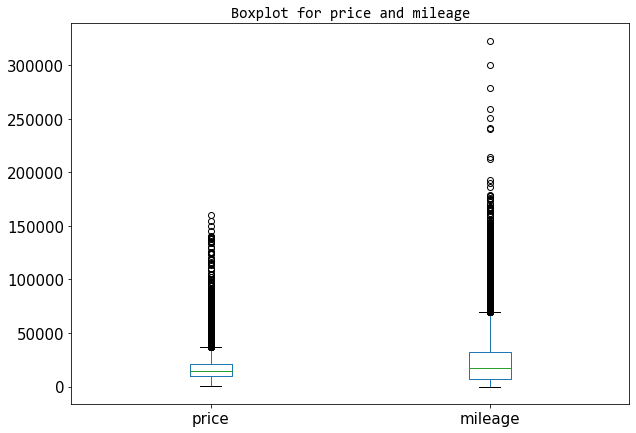

In [29]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(df.boxplot(column=["price", "mileage"], return_type='axes', fontsize=15, grid=False))
ax.set_title('Boxplot for price and mileage', fontdict={"family": "Consolas", "size": 15})
plt.show()

Como vemos de forma visual, ambas variables tienen un número bastante alto de valores anómalos. Vamos a agrupar ahora las dos últimas variables con rango similar, `tax` y `mpg`.

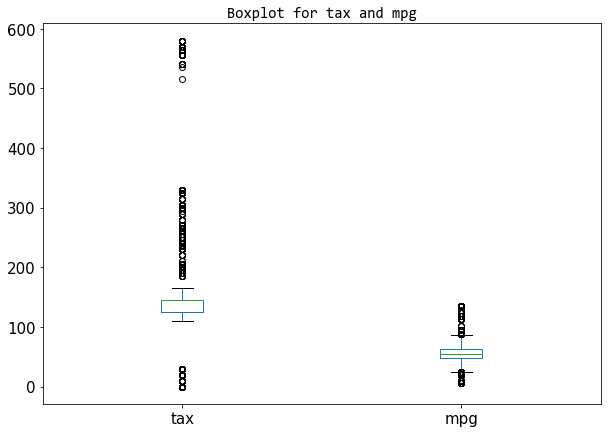

In [30]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(df.boxplot(column=["tax", "mpg"], return_type='axes', fontsize=15, grid=False))
ax.set_title('Boxplot for tax and mpg', fontdict={"family": "Consolas", "size": 15})
plt.show()

Las cuatro variables presentan valores anómalos importantes, además si se tienen en cuenta los estadísticos de la tabla mostrada por el método *describe*, la desviación estándar y el coeficiente de variación debemos abordar algunos cambios que favorecerán la precisión de nuestros modelos.

#### 2.5.3. Tests de normalidad

El [test de Kolmogorov-Smirnov](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) nos permite ver si una variable sigue una distribución normal o no.

In [31]:
numeric_variables = ["year", "price", "mileage", "tax", "mpg", "engineSize"]

for column in numeric_variables:
    mu, sigma = norm.fit(df[column].dropna())
    n = norm(loc=mu, scale=sigma)
    print(
        f"{column}: hypothesis {'rejected' if kstest(df[column].dropna(), n.cdf).pvalue < 0.05 else 'not rejected'}"
    )

year: hypothesis rejected
price: hypothesis rejected
mileage: hypothesis rejected
tax: hypothesis rejected
mpg: hypothesis rejected
engineSize: hypothesis rejected


Parece que ninguna de ellas sigue una distribución normal. Sin embargo, es posible aproximar una normal, así que vamos a echar un vistazo a los histogramas.

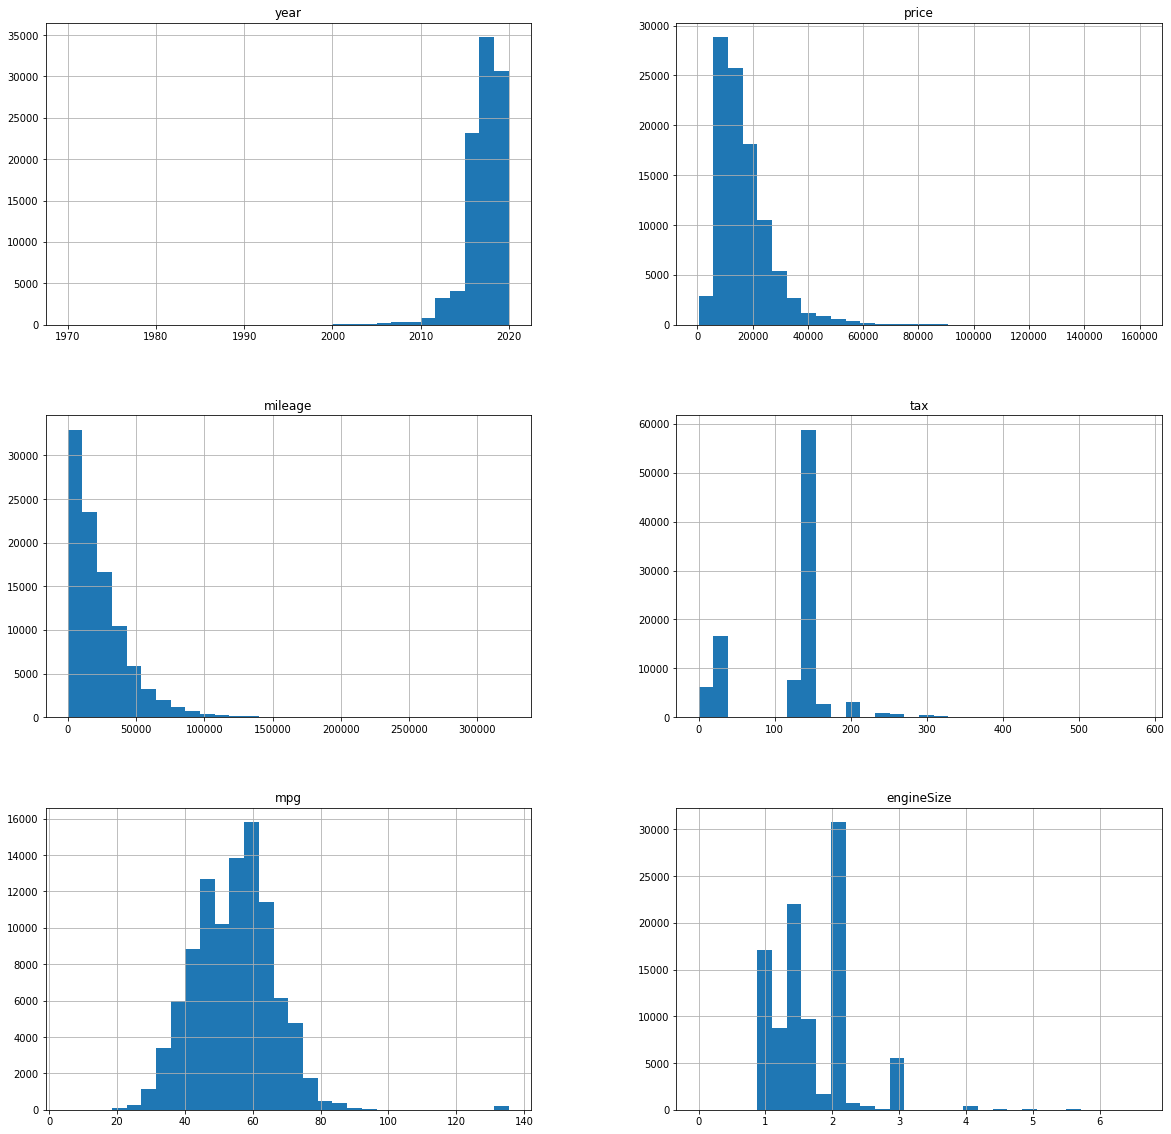

In [32]:
df[numeric_variables].hist(figsize=(20, 20), bins=30)
plt.show()

La variable `mpg` parece que podría ser normal si no fuera por sus outliers. Si eliminando los outliers la distribución es normal, podremos plantearnos normalizar en el preprocesamiento.

Not a normal distribution


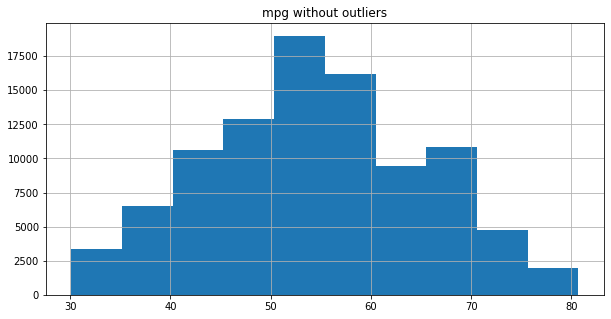

In [33]:
mpg_std = df["mpg"][(df["mpg"] < np.percentile(df["mpg"].dropna(), 99))
                    & (df["mpg"] > np.percentile(df["mpg"].dropna(), 1))]

mu, sigma = norm.fit(mpg_std)
n = norm(loc=mu, scale=sigma)
if kstest(mpg_std, n.cdf).pvalue < 0.05:
    print("Not a normal distribution")
else:
    print("Test inconclusive")

plt.figure(figsize=(10, 5))
plt.hist(mpg_std, bins=10)
plt.grid(True)
plt.title("mpg without outliers")
plt.show()

La distribución de `mpg` no es normal aunque se eliminen estos outliers. Los tests dan p-valores menores de 0.05 y el histograma está sesgado a la derecha.

### 2.6. Análisis de variables categóricas

Vamos a echar un vistazo a los posibles valores que toman las variables categóricas.

#### 2.6.1. Atributo `model`

En el caso de la variable `model`, lo primero es ver cuántos tipos de modelos distintos podemos encontrarnos.

In [34]:
len(df["model"].unique())

192

Codificar `model` con un one-hot encoding implicaría aumentar la dimensionalidad de los datos en 193, lo cual probablemente sea perjudicial para el modelo y desde luego para el coste computacional. Vamos a ver si podemos deshacernos de la variable.

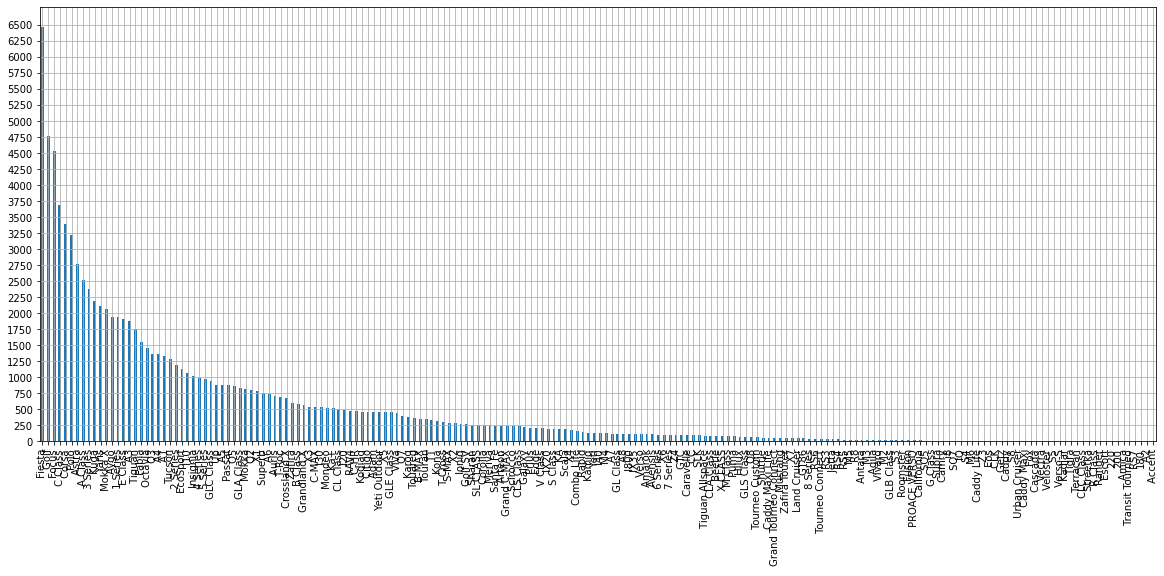

In [35]:
plt.figure(figsize=(20, 8))
df["model"].value_counts().plot(kind="bar")
plt.grid()
plt.yticks(range(0, 6501, 250))
plt.show()

Parece que la gran mayoría de modelos tienen un número reducido de instancias. Sin embargo, hay suficientes datos de suficientes modelos como para que sea más acertado conservar la variable que eliminarla. Codificaremos `model` con un one-hot encoding.

#### 2.6.2. Atributos `transmission` y `fuelType`

Lo primero es observar los posibles valores que toman las variables.

In [36]:
for column in ["transmission", "fuelType"]:
    print(column, end=': ')
    print(set(df[column].unique()))

transmission: {'Semi-Auto', 'Manual', 'Automatic', 'Other'}
fuelType: {'Diesel', 'Hybrid', 'Other', 'Petrol'}


Estos datos están bastante limpios, así que no hará falta preprocesarlos demasiado. El tipo 'Other' puede que dé problemas, así que vamos a mirar cuántos hay de esos.

In [37]:
print(f"transmission=Other count: {len(df[df['transmission'] == 'Other'])}")
print(f"fuelType=Other count: {len(df[df['fuelType'] == 'Other'])}")

transmission=Other count: 7
fuelType=Other count: 217


EL número de filas con valor "Other" para `transmission` y `fuelType` es relativamente bajo, así que no van a afectar significativamente al modelo.

### 2.7. Análisis de correlaciones

Puede ser interesante observar las correlaciones entre las variables de entrada y la variable objetivo, ya que si hay alguna variable que no afecte al resultado, podremos eliminarla sin problemas simplificando el espacio de búsqueda.

#### 2.7.1. Correlaciones con variables numéricas

En primer lugar, observamos las correlaciones ([Pearson $r$](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) con las variables numéricas.

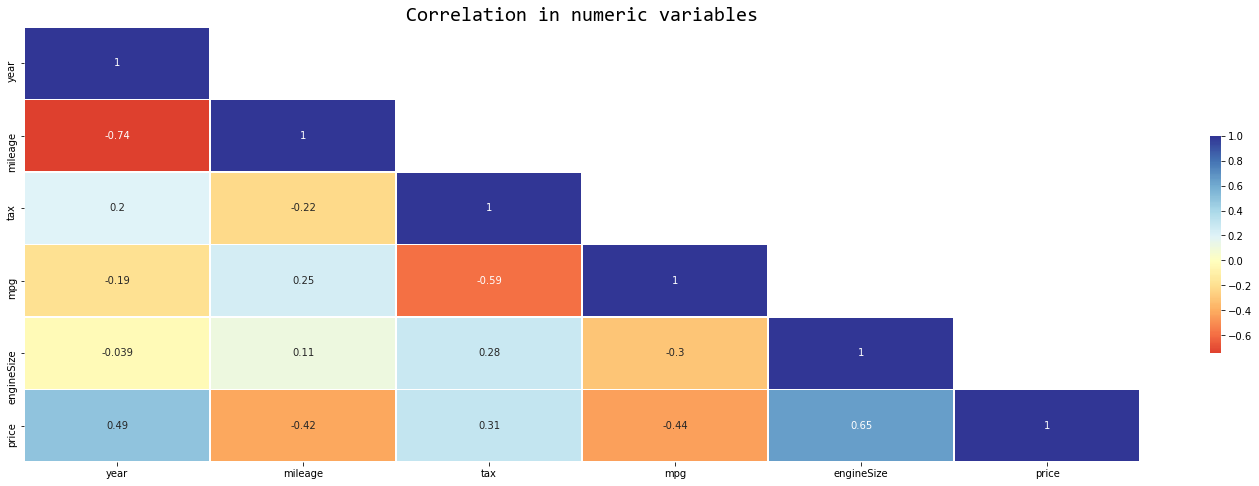

In [38]:
corr = df.corr(method="pearson")

plt.figure(figsize=(25, 8))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(corr, mask=mask, cmap="RdYlBu", center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
    
plt.title("Correlation in numeric variables", fontdict={"family": "Consolas", "size": 20})
plt.show()

En general, todos los pares de variables tienen bastante correlación. Sobre todo la variable `price`, que es nuestro objetivo. Sin embargo, en relación a la variable objetivo `price` hay otras variables como `tax` y `mpg` que presentan una correlación menor. 

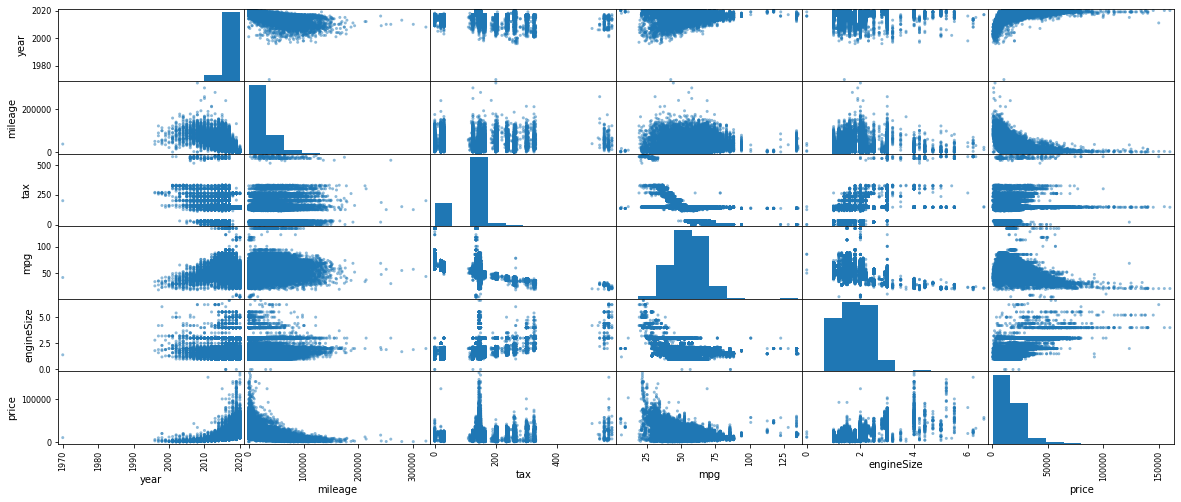

In [39]:
pd.plotting.scatter_matrix(df, figsize=(20, 8))
plt.show()

Con la matriz que muestra los diagramas de dispersión por cada par de variables podemos observar lo que ya se veía con el gráfico de correlación. Las variables que más correlación presentan con la variable objetivo `price` son `year`, `mileage` y `engineSize`.

#### 2.7.2. Correlaciones con variables categóricas

La correlación con las variables categóricas no se puede cuantificar. Sin embargo, podemos ver si hay relación entre estas variables categóricas y la variable objetivo con el [U-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) de Mann-Whitney-Wilcoxon si son dos variables, con [ANOVA](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) si son más de dos, y siempre con histogramas.

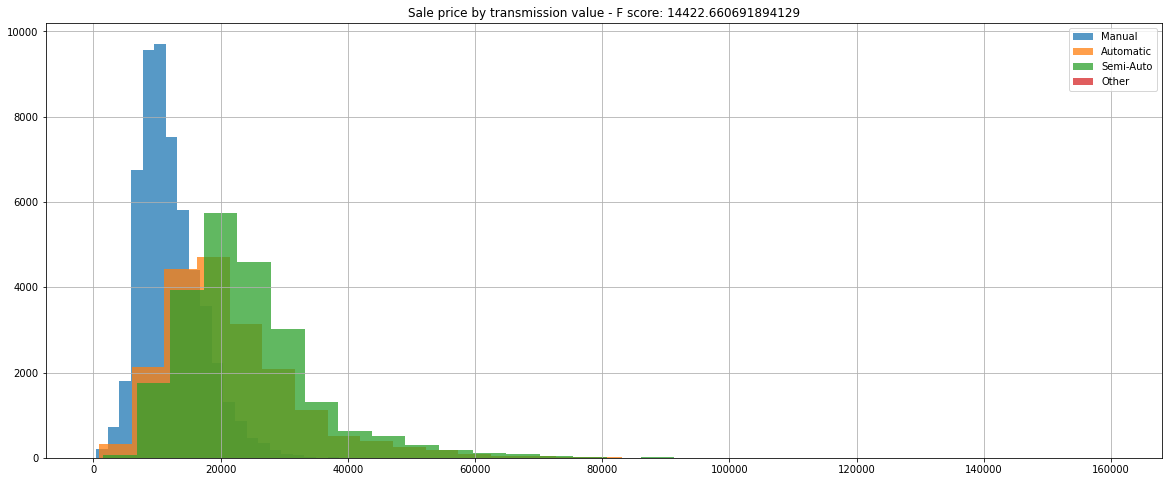

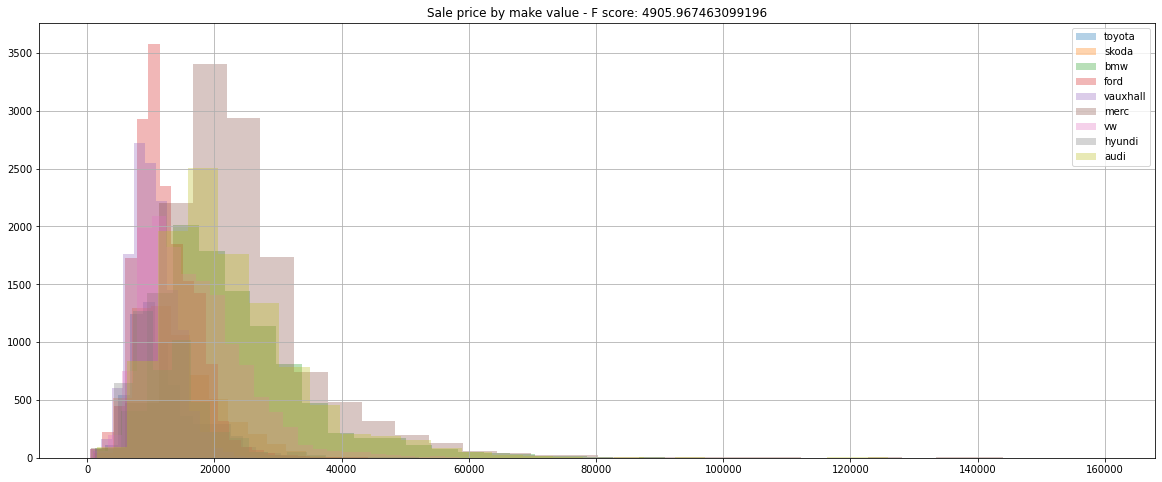

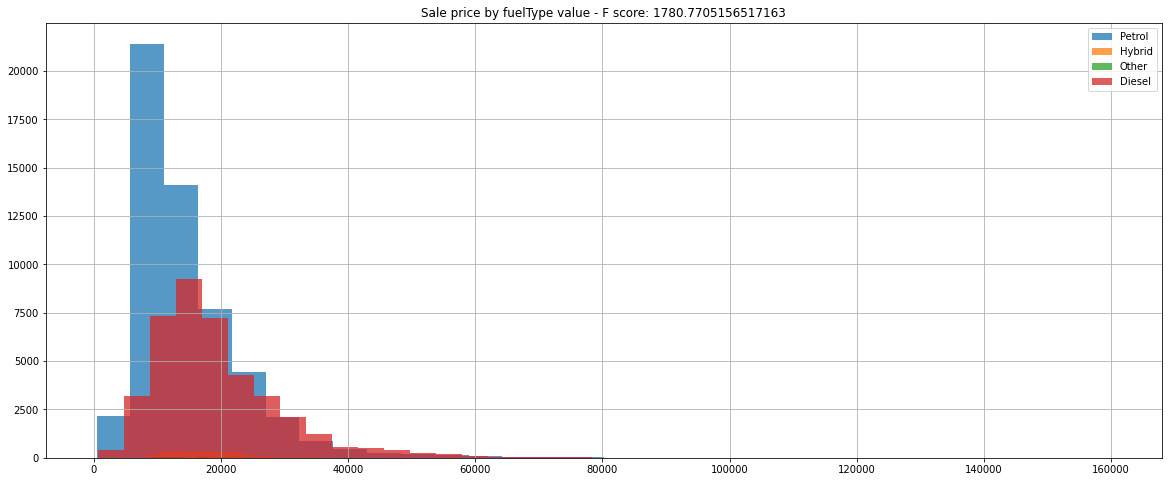

In [40]:
# Omitimos model, porque hay demasiados tipos como para hacer este test.
# Sin embargo, es evidente que el modelo es relevante a la hora de decidir el precio de venta de segunda mano.

categorical_variables = ["transmission", "make", "fuelType"]


def divide_category(df, var):
    """
    Divide a dataframe in several dataframes, grouping by variable `var`.
    """
    index = []
    ret = []
    unique_categories = df[var].unique()

    for cat in unique_categories:
        category_df = df[df[var] == cat]
        index.append(cat)
        ret.append(category_df)

    return index, ret


for var in categorical_variables:
    index, divided_data = divide_category(df, var)

    prices = [x.price for x in divided_data]

    plt.figure(figsize=(20, 8))
    if len(index) != 2:
        plt.title(f"Sale price by {var} value - F score: {f_oneway(*prices).statistic}")
    else:
        plt.title(f"Sale price by {var} value - U score: {mannwhitneyu(*prices).statistic}")

    for i, category_data in zip(index, divided_data):
        plt.hist(category_data.price, label=i, alpha=3 / len(index), bins=30)

    plt.legend()
    plt.grid()
    
    plt.show()

La explicación de esto es que, si al dividir el dataset por una variable en particular, las distribuciones del precio son diferentes, significará que hay una correlación entre la variable y el precio. Todas las variables están claramente relacionadas con la variable objetivo: los histogramas tienen poco que ver entre ellos y el test ANOVA da un resultado mayor a 1000 en todos los casos.

Parece que todas las variables son relevantes para la variable objetivo, y no nos podemos deshacer de ninguna.

## 3. Preprocesamiento

Para el preprocesamiento de los datos vamos a crear un pipeline estructurado, que aplique una serie de pasos a cada columna con cuidado.

### 3.1 Tratamiento de valores duplicados

Como mencionamos en el punto anterior, vamos a eliminar las filas duplicadas de los datos.

In [41]:
df.drop_duplicates(inplace=True)

### 3.2. Shuffle y separación en *X* e *y*

Vamos a barajar los datos de forma aleatoria para el modelo, y separar los datos de entrada de la variable objetivo.

In [42]:
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
X = df.drop(columns=["price"])
y = df["price"]

### 3.3. Tratamiento de los valores nulos

Recordemos la existencia de valores nulos para los datos de las columnas `tax` y `mpg` que provenían de los dataset cclass.csv y focus.csv. Se necesitará realizar la predicción de estos valores para obtener un conjunto de datos sin valores nulos donde cada columna contenga información relevante para el entrenamiento futuro del modelo.

Para tratar los valores nulos, vamos a utilizar la clase [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) de sklearn, utilizando sólo los vecinos que pertenezcan a la misma marca. Hemos utilizado una clase SpecificImputer que subdivide los datos de entrada y aplica un objeto *imputer* de `sklearn` a todas las subdivisiones de los datos por separado.

In [43]:
class SpecificImputer(BaseEstimator, TransformerMixin):
    """
    Impute different parts of the data separately.
    """
    def __init__(self,
                 var=0,
                 imputer_class=SimpleImputer,
                 imputer_kwargs={},
                 fallback_var=1):
        """
        var: the attribute by which the DataFrame will be divided
        imputer: Imputer estimator. Has to implement the `fit` and `transform` methods.
        imputer_kwargs: keyword arguments to be passed to the imputer constructor.
        fallback_var: variable by which to divide if there are not enough distinct samples of var.
        """
        self.var = var
        self.fallback_var = fallback_var
        self.imputer_class = imputer_class
        self.imputers = {}
        self.fallback_imputers = {}
        self.imputer_kwargs = imputer_kwargs

    def fit(self, X, y=None):
        if type(X) is not pd.DataFrame:
            raise ValueError("SpecificImputer works on DataFrames only")

        assert self.var in X, f"Data must have {var} column"
        self.numeric_columns = X.select_dtypes(
            include=np.number).columns.tolist()

        for value in X[self.var].unique():
            self.imputers[value] = self.imputer_class(**self.imputer_kwargs)
            self.imputers[value].fit(X[X[self.var] == value][self.numeric_columns])

        for value in X[self.fallback_var].unique():
            self.fallback_imputers[value] = self.imputer_class(**self.imputer_kwargs)
            self.fallback_imputers[value].fit(X[X[self.fallback_var] == value][self.numeric_columns])

        return self

    def _impute_row(self, row):
        if any(row[self.numeric_columns].isnull()):

            try:
                imputed_row = self.imputers[row[self.var]].transform([row[self.numeric_columns]])[0]
            except ValueError: # Not enough samples of "var"
                imputed_row = self.fallback_imputers[row[self.fallback_var]].transform([row[self.numeric_columns]])[0]
                
            imputed_row = pd.Series(imputed_row, index=self.numeric_columns)

            assert not any(imputed_row.isnull())
            for column in row.index:
                if column in self.numeric_columns and pd.isnull(row[column]):
                    row[column] = imputed_row[column]
        return row

    def transform(self, X, y=None):
        return X.apply(self._impute_row, axis=1)

In [44]:
imputer = SpecificImputer(
    var="model",
    fallback_var="make",
    imputer_class=KNNImputer,
    imputer_kwargs={"weights": "distance"},
)

### 3.4. Transformación de los datos

#### 3.4.1. Pipeline de variables categóricas

In [45]:
categorical_transform = OneHotEncoder()

Las variables categóricas no necesitan demasiado preprocesamiento. Con codificar cada elemento en un vector es suficiente.

#### 3.4.2. Pipeline de variables numéricas

##### 3.4.2.1. Preprocesamiento del año (fecha)

In [46]:
def age(X):
    return DATE_BASELINE - X

date_baseliner = FunctionTransformer(age)
scaler = MinMaxScaler()

date_transform = Pipeline([
    ("baseliner", date_baseliner),
    ("scaler", scaler)
])

##### 3.4.2.2. Preprocesamiento del resto de variables numéricas

Vamos a definir un `Scaler` para las columnas numéricas que faltan por tratar. Recordemos el estudio de la variabilidad de los datos numéricos del punto 2.5.2, donde vimos que las variables numéricas tenían un coeficiente de variación bastante alto, excepto `engineSize`, por lo que si elegimos un `Scaler` que sea sensible a valores anómalos no estaremos realizando una buena elección.

Por tanto, elegimos [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) para escalar las columnas mencionadas. `RobustScaler` utiliza estadísticos robustos frente a los valores anómalos o *outliers*. Primero, resta la mediana a cada punto y luego divide por el rango intercuartílico.

In [48]:
numeric_transform = RobustScaler()

#### 3.4.3. Transformador general

In [49]:
data_transformer = ColumnTransformer([
    ("categorical_transform", categorical_transform, ["transmission", "make", "fuelType", "model"]),
    ("date_transform", date_transform, ["year"]),
    ("numeric_transform", numeric_transform, ["mileage", "tax", "mpg", "engineSize"]),
], verbose=True)

### 3.5. Pipeline completo

In [50]:
full_pipeline = Pipeline([
    ("imputer", imputer),
    ("data_transformer", data_transformer),
], verbose=True)

In [51]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Caveats with copying to a DataFrame, can be safely ignored
    preprocessed_data = full_pipeline.fit_transform(X)        

[Pipeline] ........... (step 1 of 2) Processing imputer, total= 1.4min
[ColumnTransformer]  (1 of 3) Processing categorical_transform, total=   0.1s
[ColumnTransformer]  (2 of 3) Processing date_transform, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing numeric_transform, total=   0.0s
[Pipeline] .. (step 2 of 2) Processing data_transformer, total=   0.1s


## 4. Entrenamiento de modelos

In [52]:
metrics = [
    ("r2", "r2"),
    ("neg_mean_absolute_error", "mae"),
    ("neg_root_mean_squared_error", "rmse")
]

results_df = pd.DataFrame(columns=[
    "model", "r2", "r2_params", "mae", "mae_params", "rmse", "rmse_params"
])

In [53]:
def train_model(name, estimator, param_grid):

    print(f"Running grid search for {name}...")
    combinations = list((product(*(param_grid[key] for key in param_grid))))
    print(f"Number of combinations: {len(combinations)}")
    print(f"Number of fits: {len(combinations) * CV_FOLDS}")

    gridsearch = GridSearchCV(estimator,
                              param_grid=param_grid,
                              scoring=[x[0] for x in metrics],
                              cv=CV_FOLDS,
                              refit=False,
                              verbose=1)

    with warnings.catch_warnings(), parallel_backend("loky"):
        warnings.simplefilter("ignore")
        gridsearch.fit(preprocessed_data, y)

    results = gridsearch.cv_results_
    scores, params = {}, {}
    for metric, metric_name in metrics:
        metric_result = max(results[f"mean_test_{metric}"])
        metric_params = results["params"][
            results[f"mean_test_{metric}"].tolist().index(metric_result)]

        scores[metric_name] = abs(metric_result)
        params[f"{metric_name}_params"] = metric_params
        
    return pd.Series({**{"model": name}, **scores, **params})

### 4.1. Regresión lineal

In [54]:
param_grid = {}

model = LinearRegression()

lin_reg_results = train_model("LinearRegression", model, param_grid)
display(lin_reg_results)

results_df = results_df.append(lin_reg_results, ignore_index=True)

Running grid search for LinearRegression...
Number of combinations: 1
Number of fits: 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


model          LinearRegression
r2                     0.868642
mae                     2236.26
rmse                    3570.55
r2_params                    {}
mae_params                   {}
rmse_params                  {}
dtype: object

### 4.2. Lasso

In [55]:
param_grid = {
    "alpha": [0.3]#[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
}

model = Lasso(random_state=RANDOM_SEED, max_iter=1000)

lasso_results = train_model("LassoRegression", model, param_grid)
display(lasso_results)

results_df = results_df.append(lasso_results, ignore_index=True)

Running grid search for LassoRegression...
Number of combinations: 1
Number of fits: 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


model          LassoRegression
r2                    0.868389
mae                    2242.04
rmse                   3574.05
r2_params       {'alpha': 0.3}
mae_params      {'alpha': 0.3}
rmse_params     {'alpha': 0.3}
dtype: object

### 4.3. Ridge

In [53]:
param_grid = {
    "alpha": [0.3]#[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
}

model = Ridge(random_state=RANDOM_SEED, max_iter=1000)

ridge_results = train_model("RidgeRegression", model, param_grid)
display(ridge_results)

results_df = results_df.append(ridge_results, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running grid search for RidgeRegression...
Number of combinations: 1
Number of fits: 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


model          RidgeRegression
r2                    0.860931
mae                     2262.9
rmse                   3679.99
r2_params       {'alpha': 0.3}
mae_params      {'alpha': 0.3}
rmse_params     {'alpha': 0.3}
dtype: object

### 4.4. ElasticNet

In [54]:
param_grid = {
    "alpha": [0.3],#[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "l1_ratio": [0.2, 0.5, 0.8]
}

model = ElasticNet(random_state=RANDOM_SEED, max_iter=1000)

elasticnet_results = train_model("ElasticNet", model, param_grid)
display(elasticnet_results)

results_df = results_df.append(elasticnet_results, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running grid search for ElasticNet...
Number of combinations: 3
Number of fits: 15
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.8s finished


model                               ElasticNet
r2                                    0.705973
mae                                    3529.22
rmse                                   5351.35
r2_params      {'alpha': 0.3, 'l1_ratio': 0.8}
mae_params     {'alpha': 0.3, 'l1_ratio': 0.8}
rmse_params    {'alpha': 0.3, 'l1_ratio': 0.8}
dtype: object

### 4.5. Comparación de modelos

In [55]:
display(results_df)

,model,r2,r2_params,mae,mae_params,rmse,rmse_params
0,LinearRegression,0.862243,{},2255.597629,{},3662.592436,{}
1,LassoRegression,0.861922,{'alpha': 0.3},2262.247531,{'alpha': 0.3},3666.891746,{'alpha': 0.3}
2,RidgeRegression,0.860931,{'alpha': 0.3},2262.899523,{'alpha': 0.3},3679.993312,{'alpha': 0.3}
3,ElasticNet,0.705973,"{'alpha': 0.3, 'l1_ratio': 0.8}",3529.219595,"{'alpha': 0.3, 'l1_ratio': 0.8}",5351.345998,"{'alpha': 0.3, 'l1_ratio': 0.8}"


In [56]:
filename = str(datetime.datetime.now()) + "after_fixes_2-deleting_high_mpg.csv"
filepath = os.path.join(RESULTS_PATH, filename)
assert not os.path.exists(filepath) # Avoid overwriting a previous results file
results_df.to_csv(filepath)

## 5. Conclusiones

Aquí las conclusiones, y quizá alguna visualización final de los datos.

## 6. Referencias

\[1\] Sarracino, F. and Mikucka, M. (2016). Estimation bias due to duplicated observations: a Monte Carlo simulation. https://mpra.ub.uni-muenchen.de/69064/1/

\[2\] EPA on BMW i3 model, https://www.fueleconomy.gov/feg/Find.do?action=sbs&id=41054

\[3\] EPA MPG ranking, https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=1984&year2=2021&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&YearSel=1984-2021&make=&mclass=&vfuel=&vtype=&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&pageno=1&tabView=0&rowLimit=10

\[4\] Least efficient cars, https://www.thethings.com/the-cars-with-the-worst-mpg-numbers-ever-and-what-theyre-worth-today/

\[5\] Hybrid Ford Mondeo, https://media.ford.com/content/fordmedia/feu/ch/de/news/2020/10/22/electric-era-for-mondeo-as-ford-drops-petrol-in-favour-of-hybrid.html